In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from hnn_core.utils import smooth_waveform
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast, model_network,
                   linear_scale_forward, log_scale_forward, UniformPrior, beta_tuning_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List
import dill

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [30]:
with open('surrogate_plot_data/lowfreq_optim_res_low_to_beta.pkl', 'rb') as f:
    optim_res = dill.load(f)

prior_dict = optim_res['prior_dict']
dt = optim_res['dt']
net_drive = optim_res['net_drive']
net_connectivity = optim_res['net_connectivity']
EI_array = optim_res['EI_array']
EI_dict_keys = optim_res['EI_dict_keys']
losses = optim_res['losses']
theta_dict = optim_res['theta_dict']

last_epoch = 15
EI_array = EI_array[:last_epoch, :]
losses = losses[:last_epoch]

df = pd.DataFrame(EI_array, columns=EI_dict_keys)
network_data_drive = Network_Data(net_drive, soma_filter=True)
network_data_connectivity = Network_Data(net_connectivity, soma_filter=True)

In [31]:
dataset_type = 'connected'
dataset_indices = [0]

model_architecture = {'L5_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L2_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L5_basket': {'hidden_dim': 8, 'n_layers': 2},
                      'L2_basket': {'hidden_dim': 8, 'n_layers': 2}}

model_dict, dataset_dict = dict(), dict()
for cell_type in net_drive.cell_types:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    model_dict[cell_type] = utils.model_celltype_lstm(
        input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type])
  
    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))
    model_dict[cell_type].to(device)

In [32]:
model_pytorch = model_network(net_drive, model_dict, dataset_dict, network_data_connectivity, device=device, bidirectional=False)
# model = torch.jit.script(model_pytorch).to(device)
model = model_pytorch.to(device)

In [35]:

pred_y_list = list()
out_fft_list = list()
dpl_list = list()
for plot_epoch in [0, 14]:
    for key in df.columns:
        model.EI_dict[key] = torch.tensor(df[key].values[plot_epoch]).to(device)

    # Make input spike dict initialized with prox/distal noisy drive
    input_spike_dict = dict()
    for cell_type in net_drive.cell_types:
        gid_list = net_drive.gid_ranges[cell_type]
        input_spike_dict[cell_type] = torch.from_numpy(
            np.stack([network_data_drive.input_spike_dict[gid].T for gid in gid_list])).float()[:, :, :].to(device)

    with torch.no_grad():
        model.train()
        # model.eval()
        pred_y = model(input_spike_dict['L5_pyramidal'].clone(), input_spike_dict['L2_pyramidal'].clone(),
                        input_spike_dict['L5_basket'].clone(), input_spike_dict['L2_basket'].clone())

    pred_y_list.append(pred_y)

    dpl = pred_y[1][:,:,1].mean(axis=1) + pred_y[3][:,:,1].mean(axis=1)
    dpl_l2 = pred_y[1][:,:,1].mean(axis=1)
    dpl_l5 = pred_y[3][:,:,1].mean(axis=1)

    out_fft = torch.fft.rfft(dpl).abs() ** 2
    out_fft_l2 = torch.fft.rfft(dpl_l2).abs() ** 2
    out_fft_l5 = torch.fft.rfft(dpl_l5).abs() ** 2

    freq = torch.fft.rfftfreq(pred_y[1].size(0), dt / 1e3)

    out_fft_list.append(out_fft)
    dpl_list.append(dpl.detach().cpu().numpy())

Text(0.5, 15.0, 'Epoch')

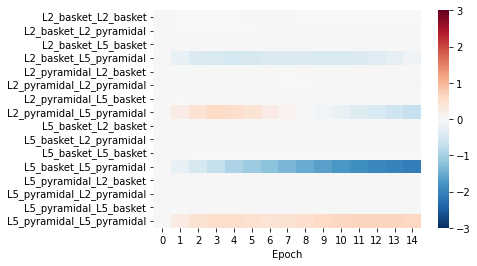

In [36]:
sns.heatmap(df.T, cmap='RdBu_r', center=0, vmin=-3, vmax=3)
plt.xlabel('Epoch')

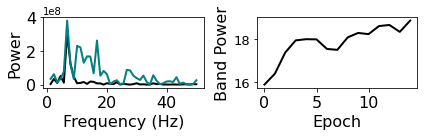

In [37]:
mask = np.logical_and(freq > 0, freq < 50).numpy().astype(bool)
fontsize = 16

plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plt.plot(freq.detach().cpu().numpy()[mask], out_fft_list[0].detach().cpu().numpy()[mask], color='k', linewidth=2, label='Initial')
plt.plot(freq.detach().cpu().numpy()[mask], out_fft_list[-1].detach().cpu().numpy()[mask], color='teal', linewidth=2, label='Final')
# plt.legend(fontsize=fontsize)

plt.xlabel('Frequency (Hz)', fontsize=fontsize)
plt.ylabel('Power', fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
# plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(-np.array(losses), color='k', linewidth=2)
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylabel('Band Power', fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=13)


plt.savefig('optim_loss.svg')
plt.tight_layout()


In [38]:
labels = list()
cell_list = ['L2i', 'L2e', 'L5i', 'L5e']
for cell1 in cell_list:
    for cell2 in cell_list:
        labels.append(cell2)

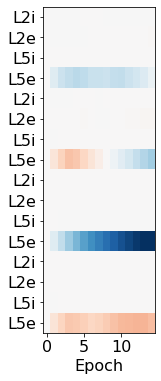

In [39]:
plt.figure(figsize=(2,6))
plt.imshow(EI_array.T, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
# plt.plot(-np.array(losses), color='k', linewidth=2)
plt.xlabel('Epoch', fontsize=fontsize)
# plt.ylabel('Band Power', fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize, labels=labels, ticks=list(range(16)))
plt.savefig('connectivity_optim.svg')

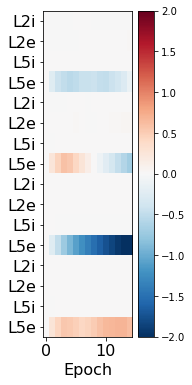

In [40]:
plt.figure(figsize=(2,6))
plt.imshow(EI_array.T, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
# plt.plot(-np.array(losses), color='k', linewidth=2)
plt.xlabel('Epoch', fontsize=fontsize)
# plt.ylabel('Band Power', fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize, labels=labels, ticks=list(range(16)))
plt.colorbar()
plt.savefig('colorbar.svg')


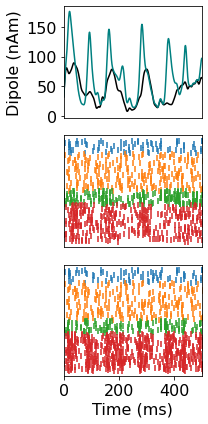

In [43]:
plt.figure(figsize=(3,6))

plt.subplot(3,1,1)
dpl_times = np.linspace(0, dpl_list[0].size * 0.5, dpl_list[0].size)
plt.plot(dpl_times, smooth_waveform(dpl_list[0], 20, (1/dt) * 1e3), c='k', label='Initial')
plt.plot(dpl_times, smooth_waveform(dpl_list[-1], 20, (1/dt) * 1e3), c='teal', label='Final')
plt.ylabel('Dipole (nAm)', fontsize=fontsize)
# _ = plt.xticks(fontsize=fontsize)
plt.xticks([])

_ = plt.yticks(fontsize=fontsize)
# plt.xlabel('Time (ms)', fontsize=fontsize)

plt.xlim(0,500)

plt.subplot(3,1,2)
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y_list[0][idx][:,:,0].detach().cpu().numpy()

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net_connectivity.gid_ranges[cell_type])[0]

    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

# plt.xlabel('Time (ms)', fontsize=fontsize)
# _ = plt.xticks(fontsize=fontsize)
plt.xticks([])
_ = plt.yticks([])
plt.xlim(0,500)
plt.gca().invert_yaxis()
plt.tight_layout()

plt.subplot(3,1,3)
for idx, cell_type in enumerate(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']):
    out = pred_y_list[-1][idx][:,:,0].detach().cpu().numpy()

    threshold = model.threshold_dict[cell_type].detach().cpu().numpy()

    cell_spikes = (out > threshold) & (np.roll(out, 1, axis=0) < threshold)
    cell_spike_indices = np.where(cell_spikes > 0)
    offset =  list(net_connectivity.gid_ranges[cell_type])[0]

    plt.scatter(cell_spike_indices[0] * 0.5, cell_spike_indices[1] + offset, c=f'C{idx}', marker='|', label=cell_type)

plt.xlabel('Time (ms)', fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.yticks([])
plt.gca().invert_yaxis()
plt.xlim(0,500)

plt.tight_layout()

plt.savefig('dipole_raster.svg')